<a href="https://colab.research.google.com/github/JiaxinLi-lipluszn/Organized-Notebook/blob/main/Perturb_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
%matplotlib inline

In [2]:
import os
os.chdir("/content/drive/Shareddrives/Documentation/Data/Yale_Perturb/")

In [ ]:
#!unzip processed.zip

Archive:  processed.zip
replace __MACOSX/._processed? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
os.chdir("./processed")

In [ ]:
!pip install scanpy

In [5]:
import scanpy
import pandas as pd

In [6]:
sc_object = scanpy.read_h5ad("crispr_shallow.h5ad")

In [7]:
sc_object

AnnData object with n_obs × n_vars = 16585 × 15125
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'leiden', 'feature_call', 'raw_scv2', 'Infected', 'new_feature_call', 'sgRNA', 'size', 'labels'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'Infected_colors', 'batch_colors', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Explain the meta file
* infected: idicating if the cell is effected by SARS CoVid virus (Not indicating if the cell has been perturbed)
* labels: Only 6435 cells are with labels, the labels distrubution are as below


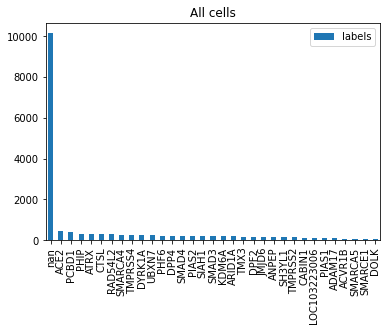

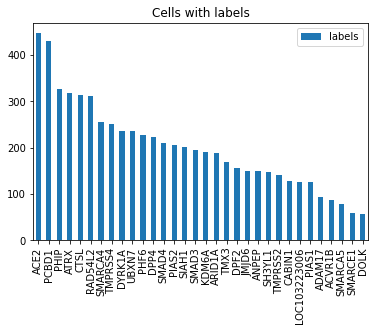

In [8]:
x = pd.DataFrame(sc_object.obs['labels'].value_counts())
x.plot.bar(title = "All cells")
x.drop(index = "nan").plot.bar(title = "Cells with labels")

## Meta dataframe

In [9]:
sc_object.obs

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pmito,n_genes,leiden,feature_call,raw_scv2,Infected,new_feature_call,sgRNA,size,labels
AAACCCAAGGTAATCA-1-SARS2,SARS2,1064,6.970730,1981.0,7.591862,26.249369,37.607269,50.782433,71.529531,0.0,1064,3,ACE2-4,1.0,Bystander,ACE2,ACE2,4,ACE2
AAACCCAAGTTGGAGC-1-SARS2,SARS2,1699,7.438384,4330.0,8.373553,28.729792,38.568129,49.838337,68.729792,0.0,1699,2,KDM6A-1,4.0,Bystander,KDM6A,Other guide,1,KDM6A
AAACCCAGTGGTGATG-1-SARS2,SARS2,1068,6.974479,1895.0,7.547502,25.171504,35.567282,48.601583,70.026385,0.0,1068,9,nan,14.0,Infected,None,None,1,nan
AAACGAAAGACCCGCT-1-SARS2,SARS2,1054,6.961296,1781.0,7.485492,22.852330,33.576642,46.715328,68.893880,0.0,1054,3,SMARCA4-1,2.0,Bystander,SMARCA4,Other guide,1,SMARCA4
AAACGAAAGGAAAGGT-1-SARS2,SARS2,1310,7.178545,2615.0,7.869402,26.118547,36.596558,48.986616,69.024857,0.0,1310,3,nan,11.0,Infected,None,None,1,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,MOCK,283,5.648974,373.0,5.924256,37.533512,50.938338,77.747989,100.000000,0.0,283,1,nan,0.0,Mock,None,None,1,nan
TTTGTTGTCACCGCTT-1-MOCK,MOCK,383,5.950643,509.0,6.234411,30.058939,44.400786,64.047151,100.000000,0.0,383,0,nan,0.0,Mock,None,None,1,nan
TTTGTTGTCCACTTTA-1-MOCK,MOCK,331,5.805135,416.0,6.033086,32.451923,44.471154,68.509615,100.000000,0.0,331,0,PHF6-4,0.0,Mock,PHF6,Other guide,1,PHF6
TTTGTTGTCTCCGAGG-1-MOCK,MOCK,556,6.322565,1051.0,6.958448,39.010466,52.331113,66.127498,94.671741,0.0,556,4,nan,0.0,Mock,None,None,1,nan


# Information about genes

In [10]:
sc_object.var.loc['ACE2',]

gene_ids                            ACE2
feature_types            Gene Expression
n_cells_by_counts                     76
mean_counts                   0.00419033
log1p_mean_counts             0.00418157
pct_dropout_by_counts             99.581
total_counts                          76
log1p_total_counts               4.34381
n_cells                               74
Name: ACE2, dtype: object

In [11]:
sc_object.var

,gene_ids,feature_types,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells
BET1L,BET1L,Gene Expression,867,0.049402,0.048220,95.219717,896.0,6.799056,866
RIC8A,RIC8A,Gene Expression,566,0.031979,0.031478,96.879307,580.0,6.364751,566
SIRT3,SIRT3,Gene Expression,153,0.008546,0.008510,99.156421,155.0,5.049856,152
PSMD13,PSMD13,Gene Expression,2730,0.173568,0.160049,84.947897,3148.0,8.054840,2719
ATHL1,ATHL1,Gene Expression,56,0.003143,0.003138,99.691239,57.0,4.060443,56
...,...,...,...,...,...,...,...,...,...
RPGR,RPGR,Gene Expression,4,0.000221,0.000221,99.977946,4.0,1.609438,4
LOC103247444,LOC103247444,Gene Expression,3,0.000165,0.000165,99.983459,3.0,1.386294,3
DDX3Y,DDX3Y,Gene Expression,13,0.000717,0.000717,99.928323,13.0,2.639057,13
LOC103247455,LOC103247455,Gene Expression,7,0.000386,0.000386,99.961405,7.0,2.079442,7


In [12]:
sc_object.obs['Infected'].value_counts()

Mock         12487
Bystander     2202
Infected      1896
Name: Infected, dtype: int64

In [13]:
sc_object.obs['batch'].value_counts()

MOCK     12487
SARS2     4098
Name: batch, dtype: int64

# Expression matrix

In [14]:
sc_object.X

<16585x15125 sparse matrix of type '<class 'numpy.float32'>'
	with 11243060 stored elements in Compressed Sparse Row format>

# EM algorithm to fit the importance of each perturbation
Adapted code based on https://github.com/asncd/MIMOSCA/blob/master/contrived-em_example.ipynb

In [15]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
import sklearn
from sklearn import linear_model
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
sns.set_style('ticks')

## Bayes_cov_col

In [40]:
def bayes_cov_col(Y,X,cols,lm):
    """
    @Y    = Expression matrix, cells x x genes, expecting pandas dataframe
    @X    = Covariate matrix, cells x covariates, expecting pandas dataframe
    @cols = The subset of columns that the EM should be performed over, expecting list
    @lm   = linear model object
    """
    #EM iterateit
    Yhat=pd.DataFrame(lm.predict(X))
    Yhat.index=Y.index
    Yhat.columns=Y.columns
    SSE_all=np.square(Y.subtract(Yhat))
    X_adjust=X.copy()


    df_SSE   = []
    df_logit = []

    for curcov in cols:

        curcells=X[X[curcov]>0].index
        #print("These are currcells")
        #print(curcells)
        # Curcells are the index with perturbation in the last assignment
        
        # If we have more than 2 cells perturbed
        if len(curcells)>2:
            #print("Did I do the correction?")
            X_notcur=X.copy()
            # Set the column all zeros (Create X_0 in the paper)
            X_notcur[curcov]=[0]*len(X_notcur)
            #print(f"This is the numerators {sum(X_notcur[curcov])}")

            # Extract the covariates and expression of perturbed cells in the last assignment
            X_sub=X_notcur.loc[curcells]
            Y_sub=pd.DataFrame(Y.loc[curcells])
            
            #print(f"This is Y_sub type: {type(Y_sub)}")
            #print(f"This is Y_sub shape: {Y_sub.shape}")
            #print(f"This is Y_sub : {Y_sub}")
            ynp = np.array(Y_sub)
            dino = 2.0 * ynp.var(axis=0)
            GENE_var = pd.DataFrame(2.0 * ynp.var(axis=0))
            GENE_var.index = Y_sub.columns
            # Get the variance as the denominators here the variace is across one column 
            # (a gene's variance across all cells perturbed)
            #GENE_var= 2.0 * Y_sub.var(axis=0)
            #print(f"This is variance of sub :{Y_sub.var(axis=0)}")
            #print(f"This is GENE_var: {GENE_var}")

            # The variance could be negative????
            vargenes= GENE_var[GENE_var>0].index
            #print(f"This is the vargenes {vargenes}")

            # X_0 * beta
            Yhat_notcur=pd.DataFrame(lm.predict(X_sub))
            Yhat_notcur.index=Y_sub.index
            Yhat_notcur.columns=Y_sub.columns

            SSE_notcur=np.square(Y_sub.subtract(Yhat_notcur))
            SSE=SSE_all.loc[curcells].subtract(SSE_notcur)
            SSE_sum=SSE.sum(axis=1)

            #print(f"This is the SSE_sum: {SSE_sum}")
            #print(f"This is the SSE shape: {SSE.shape}")
            #print(f"This is before sum : {SSE.div(dino+0.5)[vargenes]}")
            SSE_transform = SSE.div(dino+0.5)[vargenes].sum(axis=1)

            #print(f"This is the SSE_transform: {SSE_transform}")
            logitify=np.divide(1.0,1.0+np.exp(SSE_transform))#sum))
            
            #print(f"This is the logitify: {logitify}")

            df_SSE.append(SSE_sum)
            df_logit.append(logitify)

            X_adjust[curcov].loc[curcells]=logitify

    return X_adjust

# Refined function (Bug free with new pandas package version)

In [41]:
def run_model_bycol(Y,X,EM_cols=None,modalpha=0.005,verbose=0):   
    """
    @Y    = Expression matrix, expecting pandas dataframe, cells x genes
    @X    = Covariate matrix, expecting pandas dataframe, cells x covariates
    @EM_cols = The subset of columns that the EM should be performed over, list
    """
    # Use the initial expression matrix and covariates assignment (perturbation) fit the inital beta
    enet=sklearn.linear_model.ElasticNet(precompute=True,l1_ratio=0.5,alpha=modalpha,max_iter=10000)
    enet.fit(X,Y)

    if verbose==1:
        print(enet.score(X,Y))


    # Be is initiated as the initial beta
    Be=pd.DataFrame(enet.coef_)
    Be.columns=X.columns
    Be.index=Y.columns
    
    # Get the predicted expression matrix Yhat from X
    Yhat=pd.DataFrame(enet.predict(X))
    Yhat.index=Y.index
    Yhat.columns=Y.columns

    if EM_cols is not None:

        # Get the new covariate matrix
        X_adjust=bayes_cov_col(Y,X,EM_cols,enet)

        print('done with EM')

        #refit model
        
        # Fit the new beta
        enet=sklearn.linear_model.ElasticNet(precompute=True,l1_ratio=0.5,alpha=0.0004,max_iter=10000)
     
        enet.fit(X_adjust,Y)
        Yhat=pd.DataFrame(enet.predict(X_adjust))
        Yhat.index=Y.index
        Yhat.columns=Y.columns

        if verbose==1:
            print(enet.score(X_adjust,Y))

        Be=pd.DataFrame(enet.coef_)
        Be.columns=X_adjust.columns
        Be.index=Y.columns
    else:
        X_adjust=X.copy()

    RES_out=Y.subtract(Yhat)  

    return(Be,X_adjust,RES_out)


In [ ]:
Y_sub

## Simulation poplulation with 2 classes cells mixed
1000 cells in the population:

Half (500) are class 1

Half (500) are class 2 

All cells with 200 genes

But only partial of these 200 genes are infrmative genes (?) (y1 and y2)

The other 180 genes are all noisy genes (y3)



In [ ]:
#simulate two multivariate normal distributions for two classes
#initial parameters
ncells=1000
ngenes=200
halfcells=int(ncells/2.0)
tenthcells=int(ncells/10.0)
informativegenes=0.1
effectsize=1.0

In [ ]:
#Simulate Class 0 cells
y1=pd.DataFrame(np.random.normal(loc=0,scale=1,size=(halfcells,int(informativegenes*ngenes))))

#Simulate Class 1 cells
y2=pd.DataFrame(np.random.normal(loc=effectsize,scale=1,size=(halfcells,int(informativegenes*ngenes))))

#Noisy genes
y3=pd.DataFrame(np.random.normal(loc=0,scale=1,size=(ncells,int(ngenes*(1.0-informativegenes)))))

#Concatenate to form cells x genes expression matrix
Y=pd.concat([y1,y2]).reset_index(drop=True)
Y=pd.concat([Y,y3],axis=1)
Y.columns=range(np.shape(Y)[1])
Y.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.184672,-0.792625,0.648055,-0.050347,0.508717,0.107486,-1.046615,0.521938,0.790880,-0.591488,3.104470,-2.033073,-0.365927,-0.415020,-1.284186,1.336862,-0.772027,-0.168706,0.034208,0.850177,1.633665,-0.295081,0.384805,-0.965746,0.461183,-0.642384,-0.938371,-2.861661,1.535388,-0.885367,1.464194,1.662718,2.388654,-0.616441,1.956462,-0.548444,-1.031947,-1.261674,-2.475770,0.816362,...,-0.993154,0.247829,0.119176,0.341414,-0.343935,-0.105096,1.401945,-0.751692,-0.269400,0.917174,0.124449,-1.791661,0.255777,1.108104,1.027148,0.470784,2.270296,1.213219,-0.631104,0.540848,0.249551,0.246404,0.696739,0.743951,-1.188429,0.819576,-2.542834,-1.002773,-0.745237,0.657380,1.125289,0.871868,0.744578,0.262326,0.037353,0.372001,1.531966,-1.030079,-0.960176,0.242519
1,-0.899148,-0.357453,0.208192,0.648165,-0.219921,-1.877645,1.207674,-0.105678,2.181515,1.665523,0.900592,1.660302,1.297756,-0.138753,1.408039,0.238438,0.475095,1.820325,0.319419,-0.146665,0.225949,-0.766878,-1.010059,0.289408,0.092303,-0.102815,0.302461,-0.319515,-0.113387,-1.363226,-0.061224,-0.286851,0.282850,-0.343939,-0.902206,-0.893686,-1.435441,-2.023808,-1.838726,1.061340,...,-1.873866,1.728326,0.553783,-0.373798,-0.635076,0.279886,-1.378675,-0.369368,-1.421319,-0.976489,2.476312,0.166631,0.466068,0.214083,2.650393,-0.699333,-1.007633,1.157258,0.905817,0.781303,-0.985490,-0.882849,-0.903053,-0.005822,1.607175,-0.772809,-0.516394,0.524875,0.848269,1.463649,0.215708,-0.535262,-0.649711,-0.624220,0.375180,-0.001266,0.449456,-0.686604,0.189916,1.800061
2,0.951863,-0.113444,1.100268,1.040731,0.727793,0.352926,-0.177606,0.647163,-1.172397,-0.603172,0.115743,-1.587503,0.082532,-0.163513,-0.808680,-0.570161,-0.742152,0.854677,0.059554,-0.605428,-0.574558,-0.835924,-1.022044,-0.639817,-1.171812,-1.384562,0.082298,1.799775,-1.714571,-0.376289,-0.516148,0.985888,0.334999,0.102680,-1.264067,-1.062511,0.540802,0.931821,-1.305839,-0.963011,...,-0.154821,0.730801,-1.185805,-0.730230,0.567797,0.410070,0.307819,-2.146465,-0.248047,-0.239837,0.962239,-0.404141,0.598195,0.305632,0.896225,0.014972,-0.194276,0.376556,1.036056,0.004792,0.160561,1.265476,-0.623834,0.795259,-0.483017,0.257899,-0.718792,-1.071895,-1.450805,0.590742,0.554686,1.421924,-0.925322,0.292950,-0.612087,1.548123,-0.586012,1.462075,0.766641,-0.210772
3,-1.009493,-1.396624,1.097152,1.750441,-0.502453,0.184471,-1.414568,0.391430,0.206043,0.198266,-0.384172,0.934289,-1.043319,0.488702,1.120080,-1.645179,0.019156,0.903667,1.508588,-0.328271,-0.956908,-0.411894,0.822949,0.384780,-1.316222,-0.667219,0.600519,1.324645,0.038739,1.759389,-0.607202,0.155791,0.880897,-0.919950,-0.860790,-0.394436,0.132131,1.167672,-0.217329,0.289431,...,-0.305644,0.938477,-0.519846,-0.235047,-1.292467,0.814460,-1.378550,0.012956,0.996392,0.208667,-1.149456,-0.177594,-0.816119,-0.437733,-0.672175,-0.800862,0.986119,-0.437416,-2.113669,0.395902,-0.375413,1.929525,-0.322360,-1.713725,0.936434,-0.852551,-0.703792,1.048261,-1.459800,-0.902422,0.305070,1.548857,1.522758,0.195313,0.564632,-0.636328,-2.331145,-2.579296,-0.492616,1.544336
4,-0.363843,-2.466598,1.870817,0.118800,-0.870288,0.734071,-0.831742,-1.022864,-0.832112,0.102609,-0.271545,0.066328,1.268628,-0.522562,0.305807,0.239271,2.671397,0.890273,0.630854,0.577910,0.185848,0.267770,0.084550,0.691205,1.014161,0.995174,0.334658,0.336898,-0.927414,-0.514366,-1.612537,0.334186,0.207556,-0.357082,-0.754094,1.069976,-0.457635,-1.474782,0.693710,-0.490741,...,-1.696989,-1.071017,-0.402122,1.143683,1.734832,-0.888833,-0.677460,0.377638,-1.782894,-1.371882,-1.199576,-0.218421,-0.268243,-0.624713,-0.844922,2.410411,-1.101450,0.646735,0.599699,0.485671,1.342360,-0.968975,1.053042,-0.815238,-0.357717,0.145420,0.871575,0.309054,2.105283,-0.636

In [ ]:
y3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,1.633665,-0.295081,0.384805,-0.965746,0.461183,-0.642384,-0.938371,-2.861661,1.535388,-0.885367,1.464194,1.662718,2.388654,-0.616441,1.956462,-0.548444,-1.031947,-1.261674,-2.475770,0.816362,0.065400,1.259091,0.596809,-0.253151,-0.728419,1.165682,0.977814,0.379121,-1.100883,-1.266655,-1.713489,-0.169383,-0.519565,1.384164,1.879988,1.187049,-1.142675,0.484938,-0.584828,0.441709,...,-0.993154,0.247829,0.119176,0.341414,-0.343935,-0.105096,1.401945,-0.751692,-0.269400,0.917174,0.124449,-1.791661,0.255777,1.108104,1.027148,0.470784,2.270296,1.213219,-0.631104,0.540848,0.249551,0.246404,0.696739,0.743951,-1.188429,0.819576,-2.542834,-1.002773,-0.745237,0.657380,1.125289,0.871868,0.744578,0.262326,0.037353,0.372001,1.531966,-1.030079,-0.960176,0.242519
1,0.225949,-0.766878,-1.010059,0.289408,0.092303,-0.102815,0.302461,-0.319515,-0.113387,-1.363226,-0.061224,-0.286851,0.282850,-0.343939,-0.902206,-0.893686,-1.435441,-2.023808,-1.838726,1.061340,-0.309348,-1.315571,-0.327929,0.522879,-0.706137,-0.417860,0.590352,0.885024,0.327155,-0.909162,-1.250037,-0.567293,-1.421098,-0.188828,-0.202853,-0.360695,-0.756919,-0.329593,0.463442,-0.778317,...,-1.873866,1.728326,0.553783,-0.373798,-0.635076,0.279886,-1.378675,-0.369368,-1.421319,-0.976489,2.476312,0.166631,0.466068,0.214083,2.650393,-0.699333,-1.007633,1.157258,0.905817,0.781303,-0.985490,-0.882849,-0.903053,-0.005822,1.607175,-0.772809,-0.516394,0.524875,0.848269,1.463649,0.215708,-0.535262,-0.649711,-0.624220,0.375180,-0.001266,0.449456,-0.686604,0.189916,1.800061
2,-0.574558,-0.835924,-1.022044,-0.639817,-1.171812,-1.384562,0.082298,1.799775,-1.714571,-0.376289,-0.516148,0.985888,0.334999,0.102680,-1.264067,-1.062511,0.540802,0.931821,-1.305839,-0.963011,0.493377,1.281297,0.516478,1.326660,1.355852,0.700938,1.300161,-0.097773,-0.341228,1.200982,0.688353,1.331541,-0.985246,2.059799,1.722898,1.195813,-0.350639,0.077089,-0.804101,0.470846,...,-0.154821,0.730801,-1.185805,-0.730230,0.567797,0.410070,0.307819,-2.146465,-0.248047,-0.239837,0.962239,-0.404141,0.598195,0.305632,0.896225,0.014972,-0.194276,0.376556,1.036056,0.004792,0.160561,1.265476,-0.623834,0.795259,-0.483017,0.257899,-0.718792,-1.071895,-1.450805,0.590742,0.554686,1.421924,-0.925322,0.292950,-0.612087,1.548123,-0.586012,1.462075,0.766641,-0.210772
3,-0.956908,-0.411894,0.822949,0.384780,-1.316222,-0.667219,0.600519,1.324645,0.038739,1.759389,-0.607202,0.155791,0.880897,-0.919950,-0.860790,-0.394436,0.132131,1.167672,-0.217329,0.289431,-0.480877,0.530984,1.112560,0.250485,-0.330339,-0.867383,0.206028,-0.389724,-0.641220,0.355335,0.706697,0.545749,-1.110514,0.683312,0.012343,-2.290323,0.377127,1.181424,0.209941,0.255899,...,-0.305644,0.938477,-0.519846,-0.235047,-1.292467,0.814460,-1.378550,0.012956,0.996392,0.208667,-1.149456,-0.177594,-0.816119,-0.437733,-0.672175,-0.800862,0.986119,-0.437416,-2.113669,0.395902,-0.375413,1.929525,-0.322360,-1.713725,0.936434,-0.852551,-0.703792,1.048261,-1.459800,-0.902422,0.305070,1.548857,1.522758,0.195313,0.564632,-0.636328,-2.331145,-2.579296,-0.492616,1.544336
4,0.185848,0.267770,0.084550,0.691205,1.014161,0.995174,0.334658,0.336898,-0.927414,-0.514366,-1.612537,0.334186,0.207556,-0.357082,-0.754094,1.069976,-0.457635,-1.474782,0.693710,-0.490741,-0.516362,0.197586,-0.806848,-2.125680,0.659637,-0.391937,-0.263867,0.191297,0.600993,-0.661800,0.245662,0.402034,1.313478,-0.046855,0.402307,1.129280,-1.491929,-1.860638,0.401526,-1.177151,...,-1.696989,-1.071017,-0.402122,1.143683,1.734832,-0.888833,-0.677460,0.377638,-1.782894,-1.371882,-1.199576,-0.218421,-0.268243,-0.624713,-0.844922,2.410411,-1.101450,0.646735,0.599699,0.485671,1.342360,-0.968975,1.053042,-0.815238,-0.357717,0.145420,0.871575,0.309054,2.105283,-0.

In [ ]:
X=pd.DataFrame()
classvec=[0]*halfcells
classvec.extend([1]*halfcells)
X['class']=classvec

X_noise=X.copy()

#X_noise.ix[0:tenthcells]=1   Here pandas abandoned .ix attribut of pandas so we need to change .ix to .iloc
X_noise.iloc[0:tenthcells]=1   # Here we use wrong labels of 1/10 cells

In [ ]:
X_noise

Text(0, 0.5, 'Density Estimate')

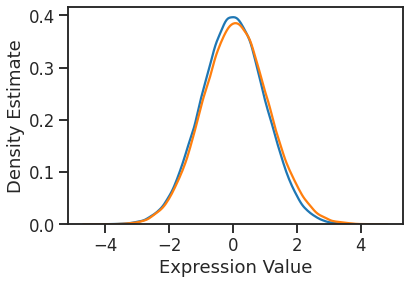

In [ ]:
#Kernel Density estimates of the two distributions across all genes
sns.kdeplot(Y.iloc[range(halfcells),:].values.flatten())
sns.kdeplot(Y.iloc[halfcells+1:,:].values.flatten())  # This is the true label (didn't use the psuedo wrong labels we've generated in the last step)
plt.xlabel('Expression Value')
plt.ylabel('Density Estimate')

Text(0, 0.5, 'Expression')

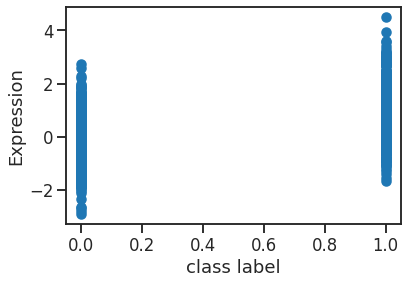

In [ ]:
#plot a single gene as a function of class membership
plt.scatter(X['class'],Y[0])
plt.xlabel('class label')
plt.ylabel('Expression')

## Here uses a simple linear regression to approximate the label (class)

In [ ]:
#Fit regression model
lm=sklearn.linear_model.Ridge()
lm.fit(X,Y)
B=pd.DataFrame(lm.coef_)

In [ ]:
B

,0
0,0.982081
1,0.964650
2,0.929859
3,1.029484
4,0.985953
...,...
195,-0.003588
196,-0.022062
197,0.014822
198,-0.031226


Text(0, 0.5, 'Coefficient')

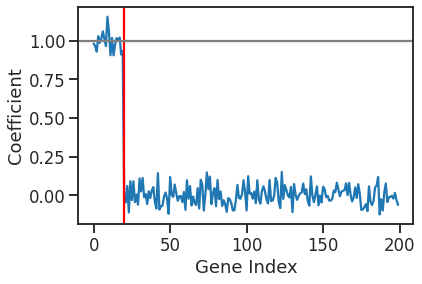

In [ ]:
#coefficients for informative subset of genes
plt.plot(B[0])
plt.axvline(ngenes*informativegenes,c='red')
plt.axhline(effectsize,c='gray')
plt.xlabel('Gene Index')
plt.ylabel('Coefficient')

In [ ]:
#Adjust covariates based on fitted coefficients
X_adjust=bayes_cov_col(Y,X,['class'],lm)

In [ ]:
X_adjust

,class
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
995,0.999929
996,0.998460
997,0.999998
998,0.995965


Text(0, 0.5, 'Class Probability')

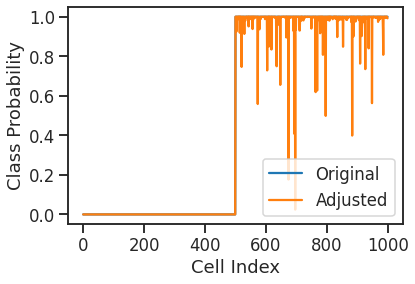

In [ ]:
#Plot original and adjusted covariates
plt.plot(X,label='Original')
plt.plot(X_adjust,label='Adjusted')
plt.legend(loc='lower right')
plt.xlabel('Cell Index')
plt.ylabel('Class Probability')

Text(0, 0.5, 'Class Probability')

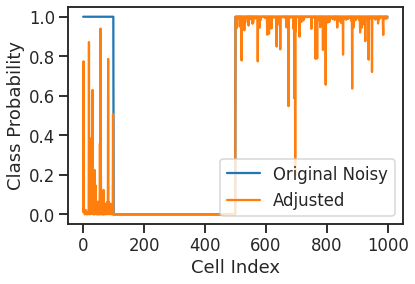

In [ ]:
#Fit regression model on noisy covariates (note how the first ten percent of cells are mostly reclassified as class 0)
lm_noise=sklearn.linear_model.Ridge()
lm_noise.fit(X_noise,Y)
B_noise=pd.DataFrame(lm_noise.coef_)
X_adjust_noise=bayes_cov_col(Y,X_noise,['class'],lm_noise)
plt.plot(X_noise,label='Original Noisy')
plt.plot(X_adjust_noise,label='Adjusted')
plt.legend(loc='lower right')
plt.xlabel('Cell Index')
plt.ylabel('Class Probability')

In [ ]:
lm_noise_adjust=sklearn.linear_model.Ridge()
lm_noise_adjust.fit(X_adjust_noise,Y)
B_noise_adjust=pd.DataFrame(lm_noise_adjust.coef_)

In [ ]:
lm_noise_adjust=sklearn.linear_model.Ridge()
lm_noise_adjust.fit(X_adjust_noise,Y)
B_noise_adjust=pd.DataFrame(lm_noise_adjust.coef_)

Text(0, 0.5, 'Coefficient')

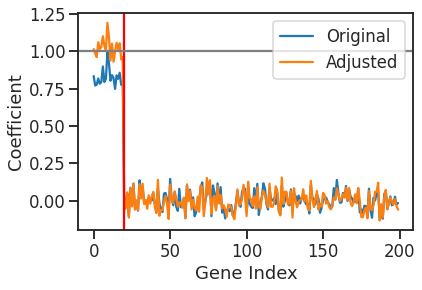

In [ ]:
#plot coefficients for informative subset of genes
plt.plot(B_noise[0],label='Original')
plt.plot(B_noise_adjust[0],label='Adjusted')
plt.axvline(ngenes*informativegenes,c='red')
plt.axhline(effectsize,c='gray')
plt.legend(loc='upper right')
plt.xlabel('Gene Index')
plt.ylabel('Coefficient')

# Apply this to our real perturb data

## Prepare data in the correct format

The bayesian function expect the expression matrix in such format


    @Y    = Expression matrix, cells x x genes, expecting pandas dataframe
    @X    = Covariate matrix, cells x covariates, expecting pandas dataframe
    @cols = The subset of columns that the EM should be performed over, expecting list
    @lm   = linear model object

### Prepare expression matrix Y

The original sparce matrix is cells by genes, so we don't need to transpose it.

Just convert sparse matrix to a pandas DataFrame with header and index.


In [17]:
sc_object.X

<16585x15125 sparse matrix of type '<class 'numpy.float32'>'
	with 11243060 stored elements in Compressed Sparse Row format>

In [19]:
import copy

In [ ]:
# Convert sparse matrix to pandas dataframe and add index and column names to it
Y = pd.DataFrame.sparse.from_spmatrix(copy.deepcopy(sc_object.X))
Y.index = copy.deepcopy(sc_object.obs.index)
Y.columns = copy.deepcopy(sc_object.var.index)
Y.head()

In [ ]:
!pwd

/content/drive/Shareddrives/Documentation/Data/Yale_Perturb/processed


In [ ]:
Y.to_csv("./stupid.csv")

In [ ]:
import numpy as np
ynp = np.array(Y)

In [ ]:
pd.DataFrame(ynp.var(axis = 0))

,0
0,0.046870
1,0.027532
2,0.008150
3,0.138669
4,0.003372
...,...
15120,0.000362
15121,0.000334
15122,0.000909
15123,0.000263


In [ ]:
Y_loaded = pd.read_csv("./stupid.csv")

In [ ]:
Y.var(axis = 0)

Series([], dtype: float64)

### Prepare covariate matrix 

Just use the meta file as this covariate matrix, of course we won't use all of the variables in it. The used variables will be specified in the next parameter

Also we need to convert the label information into a one-hot encoding matrix

In [22]:
X = sc_object.obs.copy()
X

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pmito,n_genes,leiden,feature_call,raw_scv2,Infected,new_feature_call,sgRNA,size,labels
AAACCCAAGGTAATCA-1-SARS2,SARS2,1064,6.970730,1981.0,7.591862,26.249369,37.607269,50.782433,71.529531,0.0,1064,3,ACE2-4,1.0,Bystander,ACE2,ACE2,4,ACE2
AAACCCAAGTTGGAGC-1-SARS2,SARS2,1699,7.438384,4330.0,8.373553,28.729792,38.568129,49.838337,68.729792,0.0,1699,2,KDM6A-1,4.0,Bystander,KDM6A,Other guide,1,KDM6A
AAACCCAGTGGTGATG-1-SARS2,SARS2,1068,6.974479,1895.0,7.547502,25.171504,35.567282,48.601583,70.026385,0.0,1068,9,nan,14.0,Infected,None,None,1,nan
AAACGAAAGACCCGCT-1-SARS2,SARS2,1054,6.961296,1781.0,7.485492,22.852330,33.576642,46.715328,68.893880,0.0,1054,3,SMARCA4-1,2.0,Bystander,SMARCA4,Other guide,1,SMARCA4
AAACGAAAGGAAAGGT-1-SARS2,SARS2,1310,7.178545,2615.0,7.869402,26.118547,36.596558,48.986616,69.024857,0.0,1310,3,nan,11.0,Infected,None,None,1,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,MOCK,283,5.648974,373.0,5.924256,37.533512,50.938338,77.747989,100.000000,0.0,283,1,nan,0.0,Mock,None,None,1,nan
TTTGTTGTCACCGCTT-1-MOCK,MOCK,383,5.950643,509.0,6.234411,30.058939,44.400786,64.047151,100.000000,0.0,383,0,nan,0.0,Mock,None,None,1,nan
TTTGTTGTCCACTTTA-1-MOCK,MOCK,331,5.805135,416.0,6.033086,32.451923,44.471154,68.509615,100.000000,0.0,331,0,PHF6-4,0.0,Mock,PHF6,Other guide,1,PHF6
TTTGTTGTCTCCGAGG-1-MOCK,MOCK,556,6.322565,1051.0,6.958448,39.010466,52.331113,66.127498,94.671741,0.0,556,4,nan,0.0,Mock,None,None,1,nan


In [23]:
# Get one-hot encoding
y = pd.get_dummies(X.labels)

In [84]:
cols = list(y.columns)

In [25]:
X = pd.merge(X, y, left_index = True, right_index= True)

In [26]:
X['batch'].value_counts()

MOCK     12487
SARS2     4098
Name: batch, dtype: int64

In [27]:
X['Infected'].value_counts()

Mock         12487
Bystander     2202
Infected      1896
Name: Infected, dtype: int64

In [ ]:
"""
map_class_labels = pd.DataFrame(X['labels'].value_counts())#.to_dict()
map_class_labels["labels"] = np.ones(len(X['labels'].value_counts()))#np.arange(len(X['labels'].value_counts()))
map_class_labels = map_class_labels.to_dict()
map_class_labels = map_class_labels['labels']
map_class_labels['nan'] = 0
"""

In [28]:
# Convert the string levels into integer levels
map_class_batch = {"SARS2" : 0, "MOCK" : 1}
map_class_infected = {"Bystander" : 0, "Mock" : 1, "Infected": 3}

X['batch'] = X['batch'].map(map_class_batch)
X['Infected'] = X['Infected'].map(map_class_infected)
#X['labels'] = X['labels'].map(map_class_labels)

In [29]:
X['batch'] = X['batch'].astype('int64')#.astype('category', ordered=True)
X['Infected'] = X['Infected'].astype('int64')#.astype('category', ordered=True)
#X['labels'] = X['labels'].astype('int64')#.astype('category', ordered=True)

In [ ]:
X

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pmito,n_genes,leiden,feature_call,raw_scv2,Infected,new_feature_call,sgRNA,size,labels,ACE2,ACVR1B,ADAM17,ANPEP,ARID1A,ATRX,CABIN1,CTSL,DOLK,DPF2,DPP4,DYRK1A,JMJD6,KDM6A,LOC103223006,PCBD1,PHF6,PHIP,PIAS1,PIAS2,RAD54L2,SH3YL1,SIAH1,SMAD3,SMAD4,SMARCA4,SMARCA5,SMARCE1,TMPRSS2,TMPRSS4,TMX3,UBXN7,nan
AAACCCAAGGTAATCA-1-SARS2,0,1064,6.970730,1981.0,7.591862,26.249369,37.607269,50.782433,71.529531,0.0,1064,3,ACE2-4,1.0,0,ACE2,ACE2,4,ACE2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACCCAAGTTGGAGC-1-SARS2,0,1699,7.438384,4330.0,8.373553,28.729792,38.568129,49.838337,68.729792,0.0,1699,2,KDM6A-1,4.0,0,KDM6A,Other guide,1,KDM6A,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACCCAGTGGTGATG-1-SARS2,0,1068,6.974479,1895.0,7.547502,25.171504,35.567282,48.601583,70.026385,0.0,1068,9,nan,14.0,3,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
AAACGAAAGACCCGCT-1-SARS2,0,1054,6.961296,1781.0,7.485492,22.852330,33.576642,46.715328,68.893880,0.0,1054,3,SMARCA4-1,2.0,0,SMARCA4,Other guide,1,SMARCA4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
AAACGAAAGGAAAGGT-1-SARS2,0,1310,7.178545,2615.0,7.869402,26.118547,36.596558,48.986616,69.024857,0.0,1310,3,nan,11.0,3,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,1,283,5.648974,373.0,5.924256,37.533512,50.938338,77.747989,100.000000,0.0,283,1,nan,0.0,1,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TTTGTTGTCACCGCTT-1-MOCK,1,383,5.950643,509.0,6.234411,30.058939,44.400786,64.047151,100.000000,0.0,383,0,nan,0.0,1,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TTTGTTGTCCACTTTA-1-MOCK,1,331,5.805135,416.0,6.033086,32.451923,44.471154,68.509615,100.000000,0.0,331,0,PHF6-4,0.0,1,PHF6,Other guide,1,PHF6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
TTTGTTGTCTCCGAGG-1-MOCK,1,556,6.322565,1051.0,6.958448,39.010466,52.331113,66.127498,94.671741,0.0,556,4,nan,0.0,1,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Prepare cols
The subset of columns that the EM should be performed over, a list.

In [30]:
cols = cols + ["batch", "Infected",]

### Prepare the linear model object


In [85]:
X.loc[:,cols]

,ACE2,ACVR1B,ADAM17,ANPEP,ARID1A,ATRX,CABIN1,CTSL,DOLK,DPF2,DPP4,DYRK1A,JMJD6,KDM6A,LOC103223006,PCBD1,PHF6,PHIP,PIAS1,PIAS2,RAD54L2,SH3YL1,SIAH1,SMAD3,SMAD4,SMARCA4,SMARCA5,SMARCE1,TMPRSS2,TMPRSS4,TMX3,UBXN7,nan
AAACCCAAGGTAATCA-1-SARS2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACCCAAGTTGGAGC-1-SARS2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACCCAGTGGTGATG-1-SARS2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
AAACGAAAGACCCGCT-1-SARS2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
AAACGAAAGGAAAGGT-1-SARS2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TTTGTTGTCACCGCTT-1-MOCK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TTTGTTGTCCACTTTA-1-MOCK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
TTTGTTGTCTCCGAGG-1-MOCK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
enet=sklearn.linear_model.ElasticNet(precompute=True,l1_ratio=0.5,alpha=modalpha,max_iter=10000)


In [32]:
#Fit regression model
import sklearn
lm=sklearn.linear_model.Ridge()
lm.fit(X.loc[:,cols],Y)
B=pd.DataFrame(lm.coef_)

## Visualize the coefficient

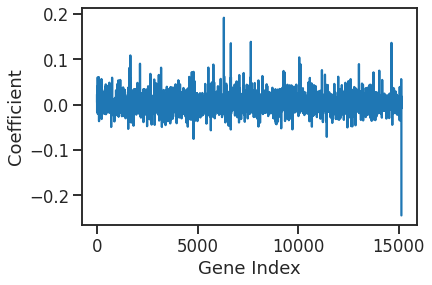

In [33]:
#coefficients for informative subset of genes
plt.plot(B[0])
#plt.axvline(ngenes*informativegenes,c='red')
#plt.axhline(effectsize,c='gray')
plt.xlabel('Gene Index')
plt.ylabel('Coefficient')
plt.show()

In [34]:
Y.shape

(16585, 15125)

# Run model

In [86]:
Be,X_adjust,RES_out = run_model_bycol(Y, X.loc[:,cols] , cols)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

done with EM


## Get the original $\beta$


In [106]:
enet=sklearn.linear_model.ElasticNet(precompute=True,l1_ratio=0.5,alpha=0.005,max_iter=10000)
enet.fit(X.loc[:,cols],Y)
Be_original=pd.DataFrame(enet.coef_)

In [107]:
Be_original.columns=X.loc[:,cols].columns
Be_original.index=Y.columns

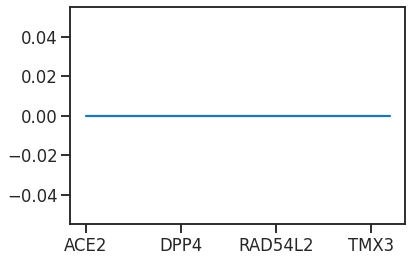

In [110]:
Be_original.loc['ACE2',:].plot()

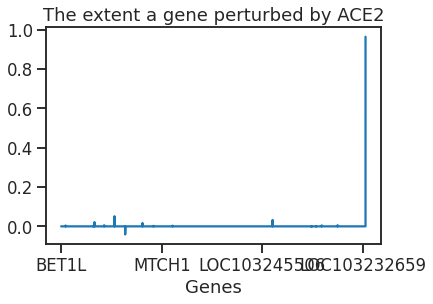

In [112]:
Be_original['ACE2'].plot(title = "The extent a gene perturbed by ACE2", xlabel = "Genes")

# Visualize

## Compare the initial covariates and the adjusted covariates

In [52]:
X_adjust['ACE2']

AAACCCAAGGTAATCA-1-SARS2    0.497423
AAACCCAAGTTGGAGC-1-SARS2    0.000000
AAACCCAGTGGTGATG-1-SARS2    0.000000
AAACGAAAGACCCGCT-1-SARS2    0.000000
AAACGAAAGGAAAGGT-1-SARS2    0.000000
                              ...   
TTTGTTGGTGTTTGCA-1-MOCK     0.000000
TTTGTTGTCACCGCTT-1-MOCK     0.000000
TTTGTTGTCCACTTTA-1-MOCK     0.000000
TTTGTTGTCTCCGAGG-1-MOCK     0.000000
TTTGTTGTCTTAGCTT-1-MOCK     0.000000
Name: ACE2, Length: 16585, dtype: float64

In [49]:
original_cells = X[X['ACE2']>0].index

In [56]:
other_cells = X[X['ACE2']==0].index

In [59]:
reorder_indices = original_cells.append(other_cells)

In [54]:
First_one_thouthand = X.iloc[0:1000,:].index

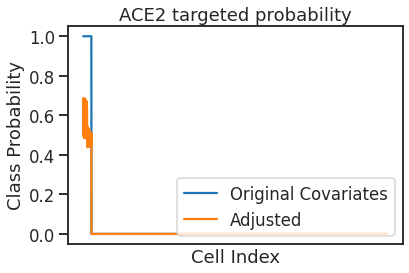

In [90]:
plt.plot(X.loc[reorder_indices,'ACE2'],label='Original Covariates')
plt.plot(X_adjust.loc[reorder_indices,'ACE2'], label='Adjusted')
plt.legend(loc='lower right')
plt.xlabel('Cell Index')
plt.ylabel('Class Probability')
plt.title("ACE2 targeted probability")
plt.xticks([])
plt.show()

# Compare the original $\beta$ and the refitted $\beta$

$\beta$ is a Gene by Covariates matrix (Different from the paper), So we can inteprete the entry of $\beta$ as the effectness of each perturbation on gene

In [63]:
# This is adjusted Beta
Be

,ACE2,ACVR1B,ADAM17,ANPEP,ARID1A,ATRX,CABIN1,CTSL,DOLK,DPF2,DPP4,DYRK1A,JMJD6,KDM6A,LOC103223006,PCBD1,PHF6,PHIP,PIAS1,PIAS2,RAD54L2,SH3YL1,SIAH1,SMAD3,SMAD4,SMARCA4,SMARCA5,SMARCE1,TMPRSS2,TMPRSS4,TMX3,UBXN7,nan,batch,Infected
BET1L,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.00000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.002160,0.010966,-0.007059
RIC8A,0.012947,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.00000,-0.00000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.004944,-0.015547,-0.009239
SIRT3,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.00000,-0.00000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000811,-0.000424
PSMD13,-0.011043,0.000000,-0.000000,0.034254,-0.000000,-0.036103,0.025722,0.000000,-0.000000,-0.000000,-0.000000,-0.013235,-0.000000,-0.00000,0.00000,-0.000000,0.000060,0.050191,-0.000000,-0.000000,-0.013363,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.014205,-0.000000,-0.060527,-0.052976,-0.020562,-0.098749
ATHL1,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.00000,0.00000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000606,-0.000090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RPGR,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.00000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
LOC103247444,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.00000,-0.00000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
DDX3Y,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.00000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000
LOC103247455,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.00000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000


For example, for ACE2 perturbation 

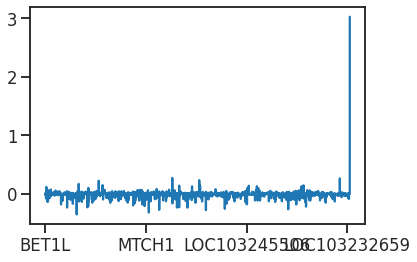

In [87]:
Be['ACE2'].plot()

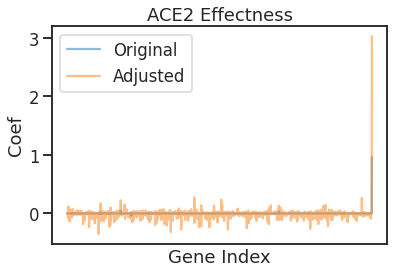

In [115]:
plt.plot(Be_original['ACE2'],label='Original', alpha = 0.5)
plt.plot(Be['ACE2'], label='Adjusted', alpha = 0.5)
plt.legend(loc='upper left')
plt.xlabel('Gene Index')
plt.ylabel('Coef')
plt.title("ACE2 Effectness")
plt.xticks([])
plt.show()

For ACE2 gene

In [105]:
Be[Be['ACE2'] > 0.05].index

Index(['CTSD', 'NUDT8', 'TRMT112', 'FTH1', 'EIF3F', 'CD63', 'SSNA1', 'BAG1',
       'CTSL', 'RPS12', 'SNX3', 'CCDC50', 'GRN', 'VPS25', 'CISD3',
       'C16H17orf89', 'LOC103222358', 'MYL12B', 'RPN2', 'CST3', 'FKBP1A',
       'CBR1', 'S100A6', 'SH3BGRL3', 'IGFBP3', 'LOC103226189', 'MGLL',
       'MGAT4B', 'RPLP1', 'LOC103245600', 'SERF2', 'CLDN4', 'FIS1', 'SERPINE1',
       'BRI3', 'LOC103231084', 'RPL37', 'GDF15', 'SPINT2', 'APOE', 'BAX',
       'FTL', 'RPS5', 'SPP1', 'EIF4EBP1', 'TMSB4X', 'SARS-CoV-2'],
      dtype='object')

In [89]:
Be.loc['ACE2','ACE2']

-0.0

In [39]:
X_adjust=bayes_cov_col(Y, X.loc[:,cols] , cols, lm)

This is Y_sub type: <class 'pandas.core.frame.DataFrame'>
This is Y_sub shape: (447, 15125)
This is Y_sub :                           BET1L  RIC8A  ...  LOC103247455  SARS-CoV-2
AAACCCAAGGTAATCA-1-SARS2    0.0    0.0  ...           0.0    0.696860
AAAGTGAGTCTCACAA-1-SARS2    0.0    0.0  ...           0.0    2.173162
AACCACAGTAGGTCAG-1-SARS2    0.0    0.0  ...           0.0    0.992548
AACGAAAAGCGCCCAT-1-SARS2    0.0    0.0  ...           0.0    1.597942
AACTTCTGTCGTTATG-1-SARS2    0.0    0.0  ...           0.0    1.928490
...                         ...    ...  ...           ...         ...
TTGGGCGAGCTGTTAC-1-MOCK     0.0    0.0  ...           0.0    0.000000
TTTACCAGTCGGTGTC-1-MOCK     0.0    0.0  ...           0.0    0.000000
TTTACTGGTCGGCACT-1-MOCK     0.0    0.0  ...           0.0    0.000000
TTTACTGTCGATCCAA-1-MOCK     0.0    0.0  ...           0.0    0.000000
TTTGGTTTCTGGGTCG-1-MOCK     0.0    0.0  ...           0.0    0.000000

[447 rows x 15125 columns]
This is GENE_var:       

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


This is Y_sub type: <class 'pandas.core.frame.DataFrame'>
This is Y_sub shape: (86, 15125)
This is Y_sub :                           BET1L    RIC8A  ...  LOC103247455  SARS-CoV-2
AACAACCCAGTGGCTC-1-SARS2    0.0  0.00000  ...           0.0   13.754425
AACAACCTCCTATGGA-1-SARS2    0.0  0.00000  ...           0.0    1.718264
AACCTTTCACAATGCT-1-SARS2    0.0  0.00000  ...           0.0    2.525577
AGGACTTTCGATAACC-1-SARS2    0.0  0.00000  ...           0.0    1.920770
AGGCATTCATCATCTT-1-SARS2    0.0  0.00000  ...           0.0    2.103574
...                         ...      ...  ...           ...         ...
TGGAACTTCCGTATAG-1-MOCK     0.0  0.00000  ...           0.0    0.000000
TTCCAATTCTCTCTTC-1-MOCK     0.0  0.00000  ...           0.0    0.000000
TTCTAACCATGAATAG-1-MOCK     0.0  0.00000  ...           0.0    0.000000
TTGGGCGAGTCGTTAC-1-MOCK     0.0  0.00000  ...           0.0    0.000000
TTTGATCGTTCCTAGA-1-MOCK     0.0  0.92064  ...           0.0    0.000000

[86 rows x 15125 columns]
Th

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


This is Y_sub type: <class 'pandas.core.frame.DataFrame'>
This is Y_sub shape: (94, 15125)
This is Y_sub :                           BET1L  RIC8A  ...  LOC103247455  SARS-CoV-2
AAGTCGTGTGAATTGA-1-SARS2    0.0    0.0  ...           0.0   23.004503
ACGTCCTTCATGAAAG-1-SARS2    0.0    0.0  ...           0.0    0.840734
AGCCAATCACACAGCC-1-SARS2    0.0    0.0  ...           0.0   15.888972
AGGATAAAGTGCACCC-1-SARS2    0.0    0.0  ...           0.0   20.382616
CACTGGGAGGCCATAG-1-SARS2    0.0    0.0  ...           0.0   18.843542
...                         ...    ...  ...           ...         ...
TTAATCCAGTGCAAAT-1-MOCK     0.0    0.0  ...           0.0    0.000000
TTACCGCTCGAGAATA-1-MOCK     0.0    0.0  ...           0.0    0.000000
TTGGGTATCGGAGCAA-1-MOCK     0.0    0.0  ...           0.0    0.000000
TTTCACAGTTGCTCCT-1-MOCK     0.0    0.0  ...           0.0    0.000000
TTTGACTCAATACGCT-1-MOCK     0.0    0.0  ...           0.0    0.000000

[94 rows x 15125 columns]
This is GENE_var:         

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


This is Y_sub type: <class 'pandas.core.frame.DataFrame'>
This is Y_sub shape: (149, 15125)
This is Y_sub :                           BET1L  RIC8A  SIRT3  ...  DDX3Y  LOC103247455  SARS-CoV-2
AACCCAAGTGCTCCGA-1-SARS2    0.0    0.0    0.0  ...    0.0           0.0    1.099798
ACTGATGGTAATACCC-1-SARS2    0.0    0.0    0.0  ...    0.0           0.0    3.172001
AGGGAGTGTAGGCTCC-1-SARS2    0.0    0.0    0.0  ...    0.0           0.0    2.038192
ATGAGGGAGGATGGCT-1-SARS2    0.0    0.0    0.0  ...    0.0           0.0    1.729228
ATTCCCGAGCTCGACC-1-SARS2    0.0    0.0    0.0  ...    0.0           0.0    2.123529
...                         ...    ...    ...  ...    ...           ...         ...
TTCGCTGCAATAGTAG-1-MOCK     0.0    0.0    0.0  ...    0.0           0.0    0.000000
TTCTAGTCACCAATTG-1-MOCK     0.0    0.0    0.0  ...    0.0           0.0    0.000000
TTCTTCCAGAGCTGCA-1-MOCK     0.0    0.0    0.0  ...    0.0           0.0    0.000000
TTGGGATTCGAGAAGC-1-MOCK     0.0    0.0    0.0  ...  

KeyboardInterrupt: ignored

In [ ]:
X_adjust

,ACE2,ACVR1B,ADAM17,ANPEP,ARID1A,ATRX,CABIN1,CTSL,DOLK,DPF2,DPP4,DYRK1A,JMJD6,KDM6A,LOC103223006,PCBD1,PHF6,PHIP,PIAS1,PIAS2,RAD54L2,SH3YL1,SIAH1,SMAD3,SMAD4,SMARCA4,SMARCA5,SMARCE1,TMPRSS2,TMPRSS4,TMX3,UBXN7,nan,batch,Infected
AAACCCAAGGTAATCA-1-SARS2,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGTTGGAGC-1-SARS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAGTGGTGATG-1-SARS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5
AAACGAAAGACCCGCT-1-SARS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGGAAAGGT-1-SARS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5
TTTGTTGTCACCGCTT-1-MOCK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5
TTTGTTGTCCACTTTA-1-MOCK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5
TTTGTTGTCTCCGAGG-1-MOCK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5


In [ ]:
X_adjust

,ACE2,ACVR1B,ADAM17,ANPEP,ARID1A,ATRX,CABIN1,CTSL,DOLK,DPF2,DPP4,DYRK1A,JMJD6,KDM6A,LOC103223006,PCBD1,PHF6,PHIP,PIAS1,PIAS2,RAD54L2,SH3YL1,SIAH1,SMAD3,SMAD4,SMARCA4,SMARCA5,SMARCE1,TMPRSS2,TMPRSS4,TMX3,UBXN7,nan,batch,Infected
AAACCCAAGGTAATCA-1-SARS2,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGTTGGAGC-1-SARS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAGTGGTGATG-1-SARS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5
AAACGAAAGACCCGCT-1-SARS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGGAAAGGT-1-SARS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5
TTTGTTGTCACCGCTT-1-MOCK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5
TTTGTTGTCCACTTTA-1-MOCK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5
TTTGTTGTCTCCGAGG-1-MOCK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5


In [ ]:
X_adjust['ACE2'].value_counts()
#X['ACE2'].value_counts()

0.0    16138
0.5      447
Name: ACE2, dtype: int64

In [ ]:
X['ACE2'].value_counts()

0    16138
1      447
Name: ACE2, dtype: int64

# **Based on the results in the above two cells, we see that the adjusted label just gave the 100% accurate prediction, which make me feel the current label is the version that has already corrected by the same algorithm**

# EM iteration

In [ ]:
def run_model_bycol(Y,X,EM_cols=None,modalpha=0.005,verbose=0):   
    """
    @Y    = Expression matrix, expecting pandas dataframe, cells x genes
    @X    = Covariate matrix, expecting pandas dataframe, cells x covariates
    @EM_cols = The subset of columns that the EM should be performed over, list
    """

    enet=sklearn.linear_model.ElasticNet(precompute=True,l1_ratio=0.5,alpha=modalpha,max_iter=10000)
    enet.fit(X,Y)
    if verbose==1:
        print(enet.score(X,Y))

    Be=pd.DataFrame(enet.coef_)
    Be.columns=X.columns
    Be.index=Y.columns

    Yhat=pd.DataFrame(enet.predict(X))
    Yhat.index=Y.index
    Yhat.columns=Y.columns

    if EM_cols is not None:

        X_adjust=bayes_cov_col(Y,X,EM_cols,enet)

        #print('done with EM')

        #refit model

        enet=sklearn.linear_model.ElasticNet(precompute=True,l1_ratio=0.5,alpha=0.0004,max_iter=10000)
     
        enet.fit(X_adjust,Y)
        Yhat=pd.DataFrame(enet.predict(X_adjust))
        Yhat.index=Y.index
        Yhat.columns=Y.columns

        if verbose==1:
            print(enet.score(X_adjust,Y))

        Be=pd.DataFrame(enet.coef_)
        Be.columns=X_adjust.columns
        Be.index=Y.columns
    else:
        X_adjust=X.copy()

    RES_out=Y.subtract(Yhat)  

    return(Be,X_adjust,RES_out)

In [ ]:
X_adjust['labels'].value_counts()
#X['labels'].value_counts()

0.0    10151
0.5     6434
Name: labels, dtype: int64

In [ ]:
pd.DataFrame(X.loc[:,'labels'] - X_adjust.loc[:,'labels']).value_counts()

labels
0.0       10151
0.5        6434
dtype: int64

In [ ]:
#Plot original and adjusted covariates
plt.plot(X.loc[:,'labels'],label='Original')
plt.plot(X_adjust.loc[:,'labels'],label='Adjusted')
plt.legend(loc='lower right')
plt.xlabel('Cell Index')
plt.ylabel('Class Probability')


In [ ]:
B[1]

0        0.016748
1        0.045969
2       -0.000631
3        0.056789
4       -0.003684
           ...   
15120   -0.000040
15121   -0.000202
15122   -0.000901
15123   -0.000251
15124   -0.638202
Name: 1, Length: 15125, dtype: float64

In [ ]:
from numpy import array
from scipy.sparse import coo_matrix
row  = array([0, 0, 1, 3, 1, 0, 0])
col  = array([0, 2, 1, 3, 1, 0, 0])
data = array([1, 1, 1, 1, 1, 1, 1])
A = coo_matrix((data, (row, col)), shape=(4, 4)).tocsc()

In [ ]:
A

<4x4 sparse matrix of type '<class 'numpy.longlong'>'
	with 4 stored elements in Compressed Sparse Column format>

# Expression matrix visulization

In [93]:
ACE2_indices = X[X['ACE2'] == 1].index

In [102]:
sum(Y.loc[ACE2_indices,'ACE2'])/len(ACE2_indices)

0.0022255987662330302

In [104]:
sum(Y['ACE2'].drop(ACE2_indices, axis = 0))/(len(Y) - len(ACE2_indices))

0.004609220842547481

# Examples

## pandas.DataFrame.var()
if axis = 0 calculate the variance accross one column

if axis = 1 calculate the variance accross one row

In [ ]:
import pandas as pd

data = [[10, 10], [10, 15], [10, 20]]

df = pd.DataFrame(data)

print(df[0].var(axis = 0))

0.0


In [ ]:
print(df.div([2,2]))

     0     1
0  5.0   5.0
1  5.0   7.5
2  5.0  10.0
